<a href="https://colab.research.google.com/github/uyenbhku/ATTACKER2022/blob/main/Remake_ATTACKER2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TRANSACTION FRAUD DETECTION - Phát hiện gian lận trong giao dịch ngân hàng**

## Setting

Download files

In [ ]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_file_id = '1tQqCmkxlAmfwfWcYcIJhIVrW2qKH5kSj'
test_file_id = '13K6qQYHXPcUCX9McIVEMa4cTYzPsZcNM'

# Download files to a local disc
download = drive.CreateFile({'id': train_file_id})
download.GetContentFile('training_set.csv')

download = drive.CreateFile({'id': test_file_id})
download.GetContentFile('test_set.csv')


## Load dataset and import libraries


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
# load training dataset
dataframe = pd.read_csv('/content/training_set.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (42,64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# load test set
test_df = pd.read_csv('/content/test_set.csv')

In [ ]:
#@title Format header 

# remove trailing and leading whitespaces in the header
dataframe = dataframe.rename(columns=lambda x: x.strip())
test_df = test_df.rename(columns=lambda x: x.strip())

## Problem definition

Phương pháp tiếp cận phần lớn dựa trên kỹ thuật, chứ mềnh hỏng có biết dề finance =))) ONTOP -> only (use) numbers to operate (data) preprocessing :v 


Dựa trên việc quan sát file description và kiến thức tổng quan, xác định:
- Dataset có 1 biến phụ thuộc là biến label, 59 biến độc lập -> tuy nhiên sẽ xem xét giảm số biến độc lập sau khi thực hiện bước Khai phá dữ liệu 
- Trong đó có 25 biến dữ liệu mang tính định tính (quanlitative)

- Bài toán: Phát hiện gian lận trong giao dịch hoặc phát hiện lừa đảo 


## Dataset splitting

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(dataframe, test_size=0.2, random_state=42, stratify=dataframe['label'])

In [ ]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
#@title Add indexes
train_df = pd.concat([train_df, pd.DataFrame({'index': np.arange(train_df.shape[0])})], axis=1)

In [ ]:
# create mask
mask = train_df.cat_5 == 1

#@title Split into 2 subsets 
subset1 = train_df[mask].drop(['cat_5'], axis=1)

subset2 = train_df[~mask].drop(['cat_5'], axis=1)

In [ ]:
#@title Store indexes
subset1_index = subset1['index']
subset1 = subset1.drop('index', axis=1)

subset2_index = subset2['index']
subset2 = subset2.drop('index', axis=1)

## Data Exploration

In [ ]:
train_df.info()

Dataset BTC cung cấp chứa 66 biến dữ liệu, trong đó:
- biến label là target value 
- biến id là transaction id -> không ảnh hưởng đến bài toán -> drop

### General

In [ ]:
drop_set = {'id'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38424 entries, 0 to 38423
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         38424 non-null  int64  
 1   label                      38424 non-null  int64  
 2   time_1                     18340 non-null  object 
 3   time_2                     18340 non-null  object 
 4   Field_11                   5313 non-null   object 
 5   cat_1                      18340 non-null  object 
 6   cat_2                      18340 non-null  object 
 7   cat_3                      18340 non-null  float64
 8   cat_4                      5292 non-null   object 
 9   cat_5                      18340 non-null  float64
 10  date_1                     11280 non-null  object 
 11  mer_des                    5995 non-null   object 
 12  mul_rate                   18340 non-null  float64
 13  value                      18340 non-null  obj

In [ ]:
# summarize percentage of unique values for each variable
# and percentage of missing values in each variable
no_var_less_than_one = 0
no_var_less_than_five = 0
no_var_more_than_80 = 0
no_var_null_more_than_70 = 0

threshold = 20 # number of categorical
no_maybe_cat_vars = 0

for col in train_df.columns:
    num = len(np.unique(train_df[col].astype(str)))
    uni_percentage = float(num) / train_df.shape[0] * 100;
    null_percentage = float(np.sum(train_df[col].isnull())) / train_df.shape[0] * 100
    
    if num < threshold:
        no_maybe_cat_vars += 1

    if uni_percentage < 1:
        no_var_less_than_one += 1
    
    if uni_percentage < 5:
        no_var_less_than_five += 1

    if uni_percentage > 80: 
        no_var_more_than_80 += 1
        drop_set.add(col)

    if null_percentage > 70:
        no_var_null_more_than_70 += 1
        drop_set.add(col)

    print(f'{col}, number of unique values: {num}, {uni_percentage:.3f}%,\t Null percentage: {null_percentage:.3f}%')


id, number of unique values: 30524, 79.440%,	 Null percentage: 0.000%
label, number of unique values: 2, 0.005%,	 Null percentage: 0.000%
time_1, number of unique values: 15835, 41.211%,	 Null percentage: 52.269%
time_2, number of unique values: 14007, 36.454%,	 Null percentage: 52.269%
Field_11, number of unique values: 713, 1.856%,	 Null percentage: 86.173%
cat_1, number of unique values: 3, 0.008%,	 Null percentage: 52.269%
cat_2, number of unique values: 3, 0.008%,	 Null percentage: 52.269%
cat_3, number of unique values: 7, 0.018%,	 Null percentage: 52.269%
cat_4, number of unique values: 12, 0.031%,	 Null percentage: 86.227%
cat_5, number of unique values: 2, 0.005%,	 Null percentage: 52.269%
date_1, number of unique values: 1407, 3.662%,	 Null percentage: 70.643%
mer_des, number of unique values: 4860, 12.648%,	 Null percentage: 84.398%
mul_rate, number of unique values: 310, 0.807%,	 Null percentage: 52.269%
value, number of unique values: 3813, 9.923%,	 Null percentage: 52.269

In [ ]:
print('Train dataset')
print(f'No. categorical columns: {no_maybe_cat_vars}')
print(f'UNIQUE VALUES:\n<1%: {no_var_less_than_one}')
print(f'<5%: {no_var_less_than_five}')
print(f'>80%: {no_var_more_than_80}')
print(f'NULL:\n>70%: {no_var_null_more_than_70}')

unknown_var_3, number of unique values: 71, 0.185%,	 Null percentage: 32.959%
unknown_var_4, number of unique values: 44, 0.115%,	 Null percentage: 56.949%
unknown_var_5, number of unique values: 21, 0.055%,	 Null percentage: 0.432%
unknown_var_6, number of unique values: 6, 0.016%,	 Null percentage: 4.750%
unknown_var_7, number of unique values: 415, 1.080%,	 Null percentage: 31.535%
unknown_var_8, number of unique values: 8512, 22.153%,	 Null percentage: 47.803%
unknown_var_9, number of unique values: 2588, 6.735%,	 Null percentage: 31.691%
unknown_var_10, number of unique values: 408, 1.062%,	 Null percentage: 32.285%
unknown_var_11, number of unique values: 4, 0.010%,	 Null percentage: 0.000%
unknown_var_12, number of unique values: 102, 0.265%,	 Null percentage: 53.722%
unknown_var_13, number of unique values: 51, 0.133%,	 Null percentage: 52.269%
unknown_var_14, number of unique values: 248, 0.645%,	 Null percentage: 52.269%
unknown_var_15, number of unique values: 239, 0.622%,	 

In [ ]:
print('Train dataset') #OLD 
print(f'No. categorical columns: {no_maybe_cat_vars}')
print(f'UNIQUE VALUES:\n<1%: {no_var_less_than_one}')
print(f'<5%: {no_var_less_than_five}')
print(f'>80%: {no_var_more_than_80}')
print(f'NULL:\n>70%: {no_var_null_more_than_70}')

Train dataset
No. categorical columns: 21
UNIQUE VALUES:
<1%: 39
<5%: 52
>80%: 1
NULL:
>70%: 11


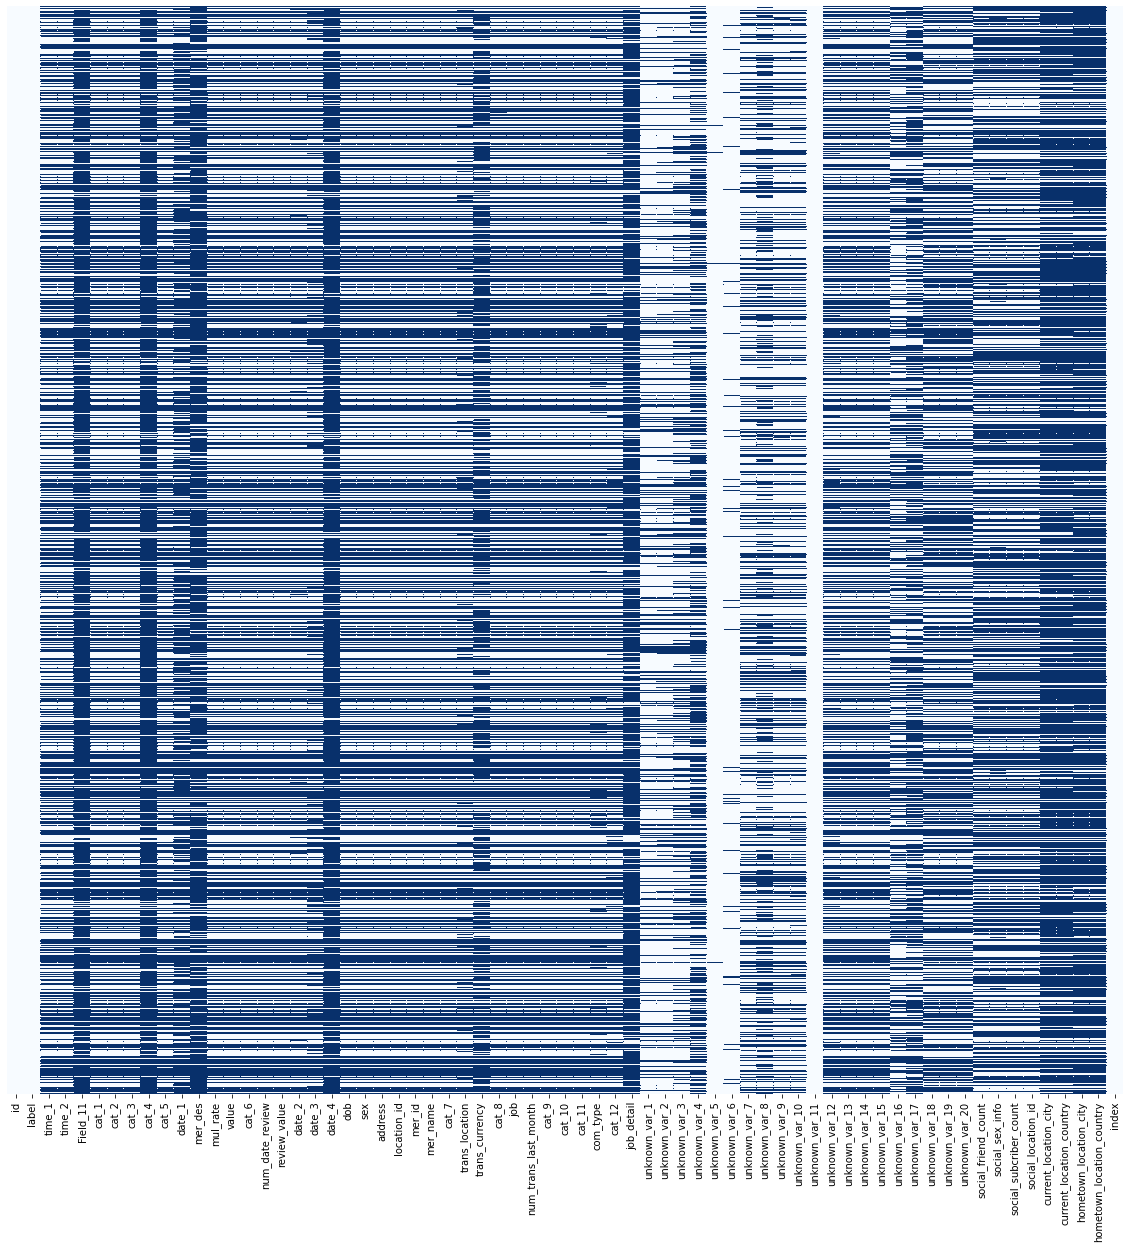

In [ ]:
# visualize missing values
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(train_df.isna(), 
            cmap='Blues', 
            cbar=False, 
            yticklabels=False);

Dựa trên thống kê số lượng missing values của các biến:
- Có 11 biến có trên số lượng dòng có missing values trên 70% -> có thể drop hết 11 biến này
- Có 26 dòng đều có cùng tỉ lệ missing values, từ heatmap có thể nhận thấy có 1 subset nằm trong cùng dataset này -> tách ra để xử lý riêng biệt

- Về cardinality, dataset có tỉ lệ unique values khá thấp -> có thể thích hợp sử dụng model cây cối 
- Với những biến có tỉ lệ cardinality cao hơn 80% thì cũng drop :v

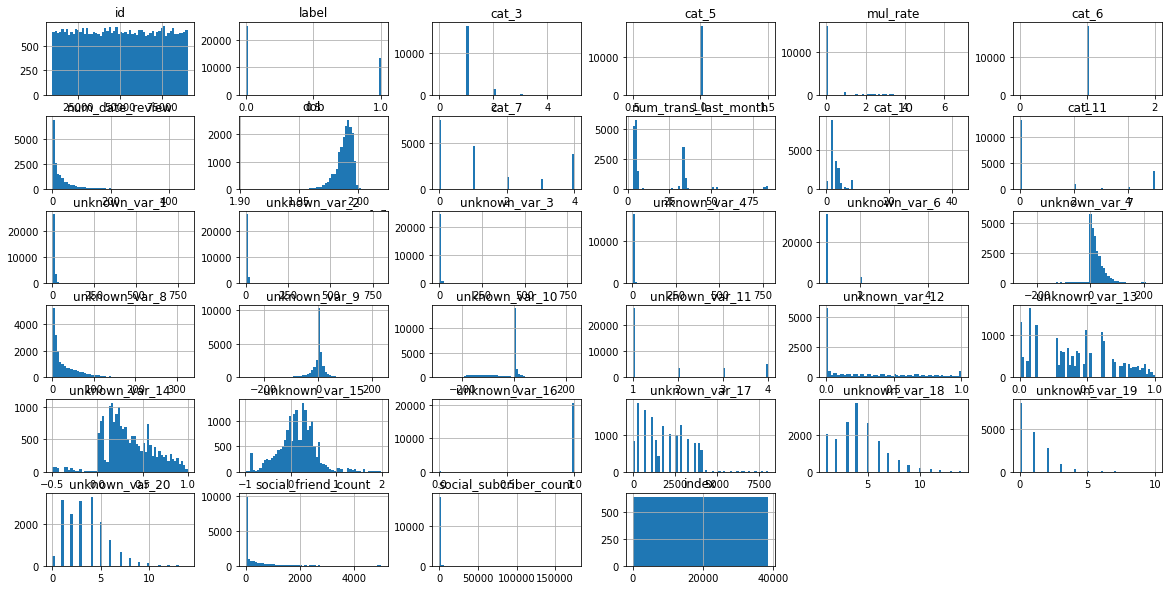

In [ ]:
train_df.hist(bins=60, figsize=(20,10));

In [ ]:
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist() 

In [ ]:
numerical_cols.remove('id')

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
# print all scatter charts of the numerical variables by id
with PdfPages('scatter_charts.pdf') as pdf:
    for col in numerical_cols:
        train_df[['id', col]].plot(kind='scatter', x='id', y=col, figsize=(40,20));
        pdf.savefig()
        plt.close()  

In [ ]:
# print all hist charts of the numerical variables
# with PdfPages('hist_charts.pdf') as pdf:
#    for col in numerical_cols:
#        train_df[col].hist(bins=60, figsize=(40,20));
#        plt.xlabel(col)
#        plt.ylabel("Number of observations")
#        pdf.savefig()
#        plt.close()

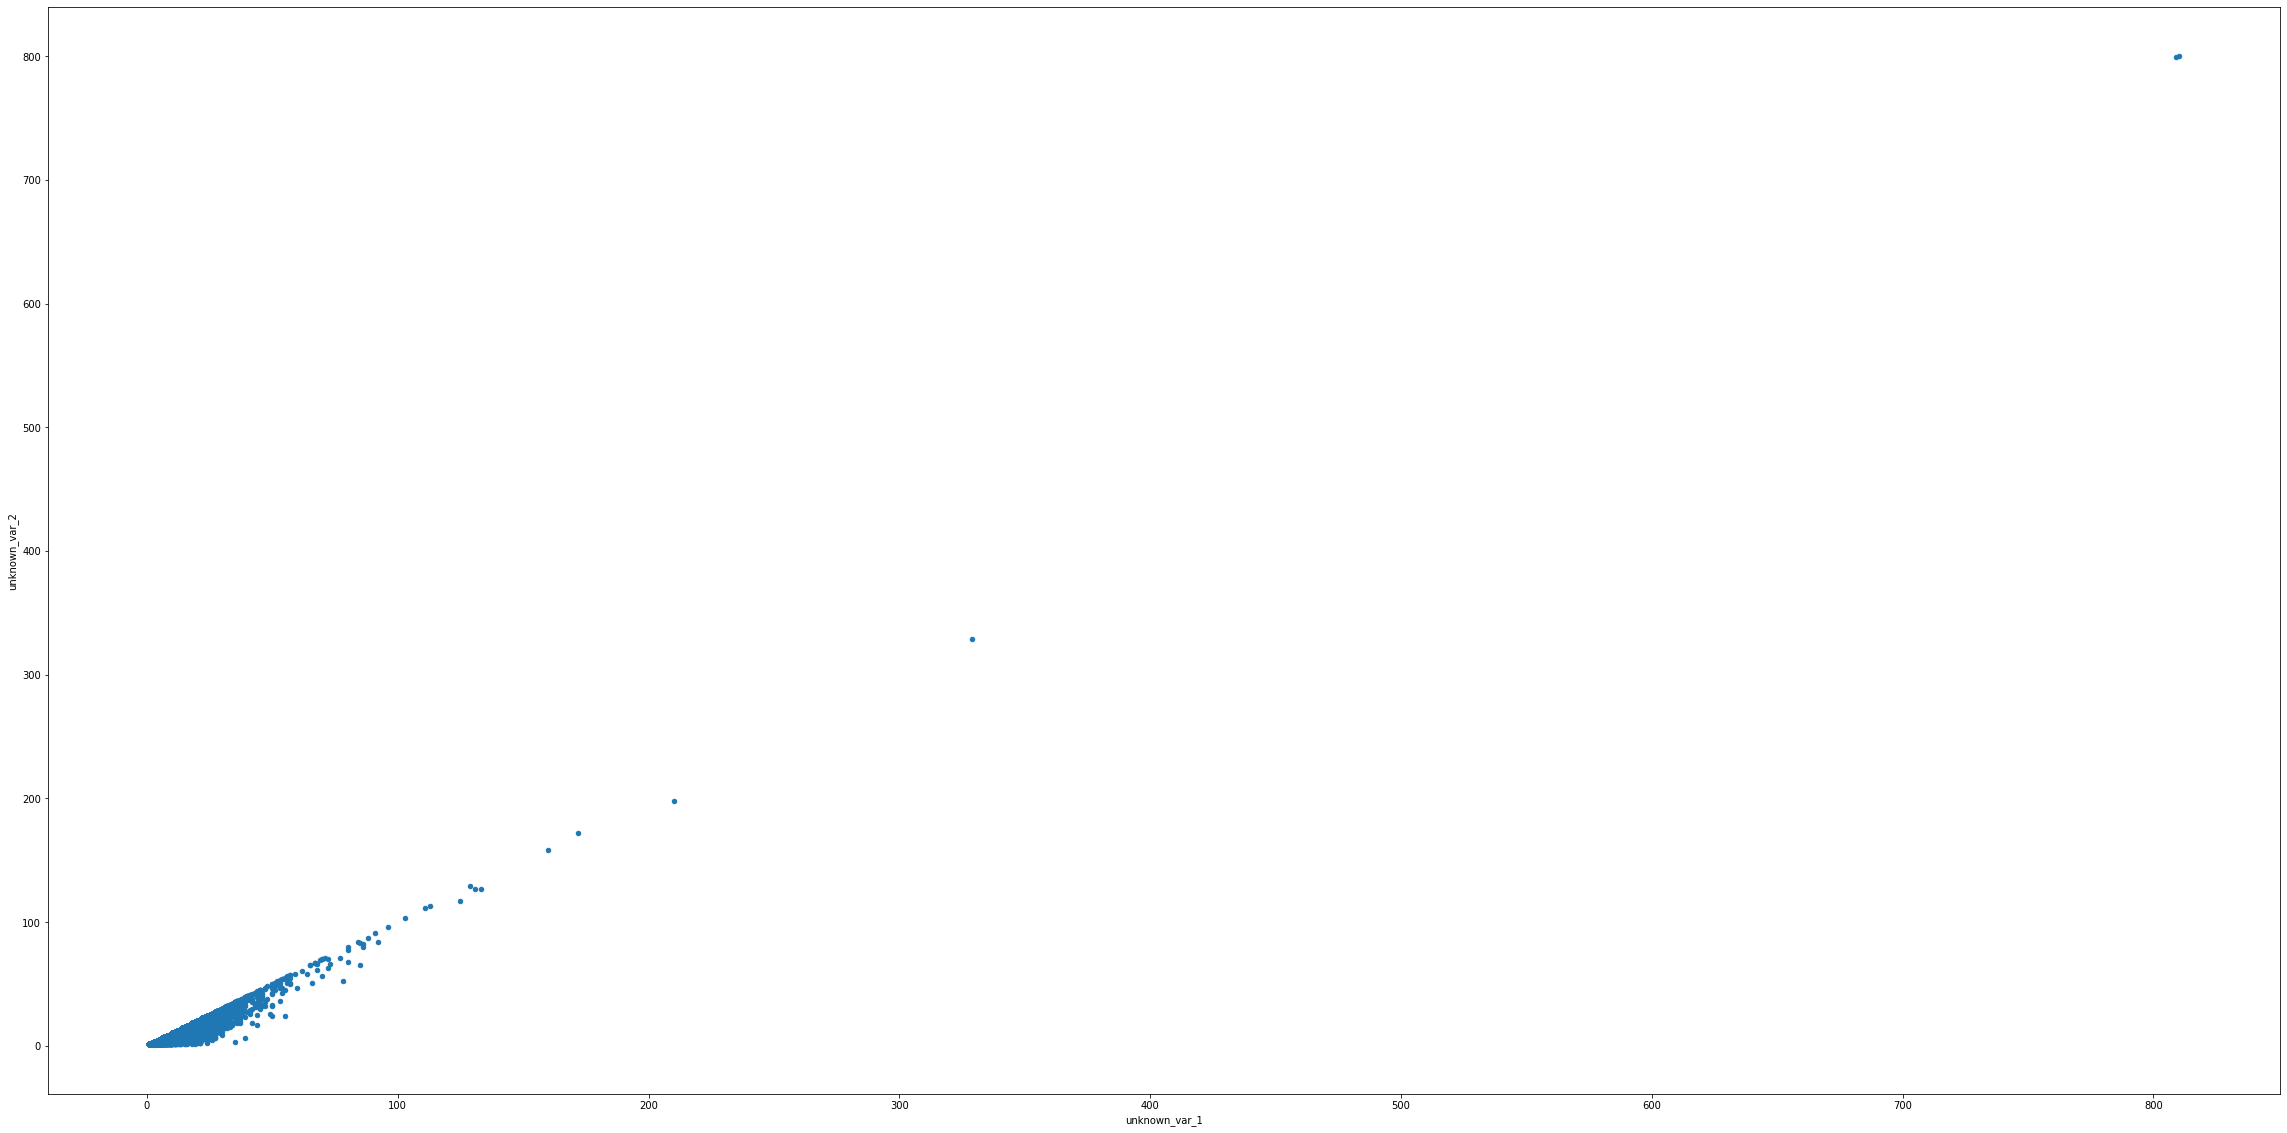

In [ ]:
train_df[['unknown_var_2', 'unknown_var_1']].plot(kind='scatter', x='unknown_var_1', y='unknown_var_2', figsize=(40,20));

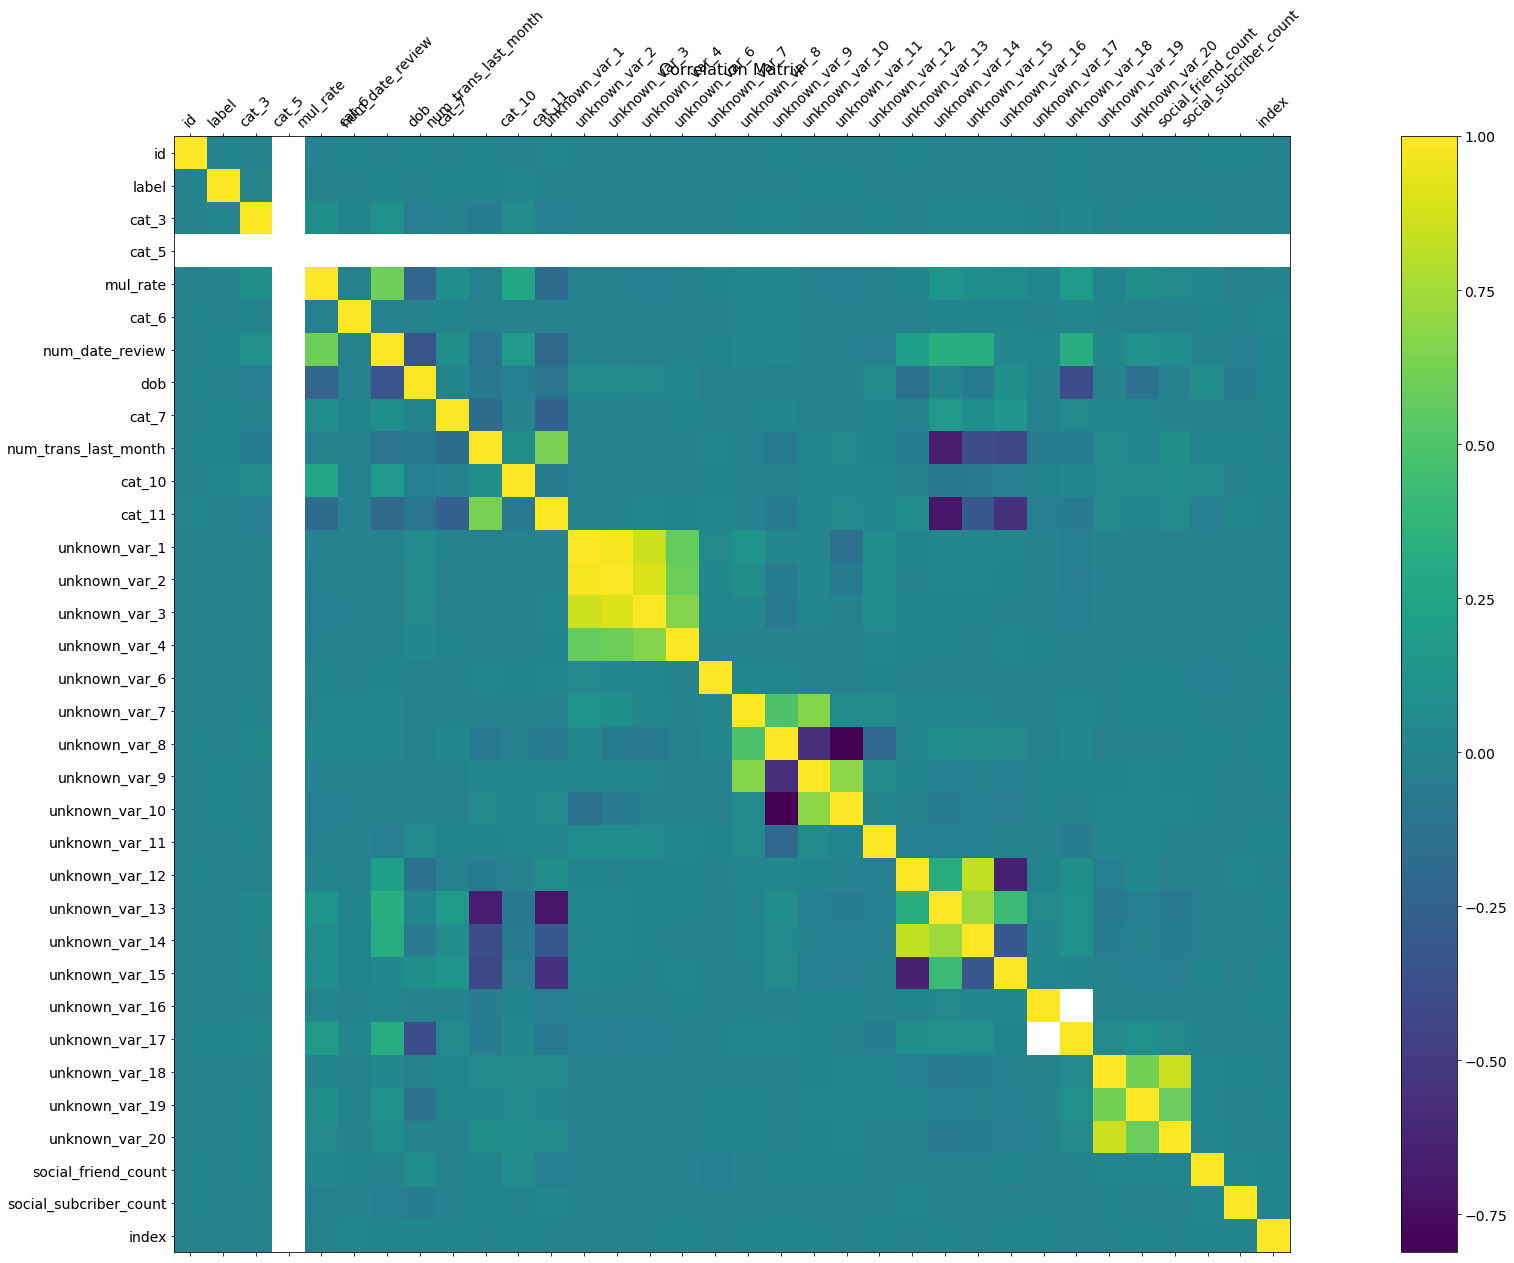

In [ ]:
f = plt.figure(figsize=(40, 20))
plt.matshow(train_df.corr(), fignum=f.number)
plt.xticks(range(train_df.select_dtypes(['number']).shape[1]), train_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train_df.select_dtypes(['number']).shape[1]), train_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Explore subsets

#### Subset 1

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18340 non-null  int64  
 1   label                      18340 non-null  int64  
 2   time_1                     18340 non-null  object 
 3   time_2                     18340 non-null  object 
 4   Field_11                   5313 non-null   object 
 5   cat_1                      18340 non-null  object 
 6   cat_2                      18340 non-null  object 
 7   cat_3                      18340 non-null  float64
 8   cat_4                      5292 non-null   object 
 9   date_1                     11280 non-null  object 
 10  mer_des                    5995 non-null   object 
 11  mul_rate                   18340 non-null  float64
 12  value                      18340 non-null  object 
 13  cat_6                      18340 non-null  flo

In [ ]:
# summarize percentage of unique values for each variable
# and percentage of missing values in each variable
no_var_less_than_one = 0
no_var_less_than_five = 0
no_var_more_than_80 = 0
no_var_null_more_than_70 = 0
subset1_drop_set = {'id'} 

threshold = 20 # number of categorical
no_maybe_cat_vars = 0

for col in subset1.columns:
    num = len(np.unique(subset1[col].astype(str)))
    uni_percentage = float(num) / subset1.shape[0] * 100;
    null_percentage = float(np.sum(subset1[col].isnull())) / subset1.shape[0] * 100
    
    if num < threshold:
        no_maybe_cat_vars += 1

    if uni_percentage < 1:
        no_var_less_than_one += 1
    
    if uni_percentage < 5:
        no_var_less_than_five += 1

    if uni_percentage > 80: 
        no_var_more_than_80 += 1
        subset1_drop_set.add(col)

    if null_percentage > 70:
        no_var_null_more_than_70 += 1
        subset1_drop_set.add(col)

    print(f'{col}, number of unique values: {num}, {uni_percentage:.3f}%,\t Null percentage: {null_percentage:.3f}%')


id, number of unique values: 16381, 89.318%,	 Null percentage: 0.000%
label, number of unique values: 2, 0.011%,	 Null percentage: 0.000%
time_1, number of unique values: 15834, 86.336%,	 Null percentage: 0.000%
time_2, number of unique values: 14006, 76.369%,	 Null percentage: 0.000%
Field_11, number of unique values: 713, 3.888%,	 Null percentage: 71.031%
cat_1, number of unique values: 2, 0.011%,	 Null percentage: 0.000%
cat_2, number of unique values: 2, 0.011%,	 Null percentage: 0.000%
cat_3, number of unique values: 6, 0.033%,	 Null percentage: 0.000%
cat_4, number of unique values: 12, 0.065%,	 Null percentage: 71.145%
date_1, number of unique values: 1407, 7.672%,	 Null percentage: 38.495%
mer_des, number of unique values: 4860, 26.499%,	 Null percentage: 67.312%
mul_rate, number of unique values: 309, 1.685%,	 Null percentage: 0.000%
value, number of unique values: 3812, 20.785%,	 Null percentage: 0.000%
cat_6, number of unique values: 3, 0.016%,	 Null percentage: 0.000%
num_d

In [ ]:
print('Subset 01')
print(f'No. categorical columns: {no_maybe_cat_vars}')
print(f'UNIQUE VALUES:\n<1%: {no_var_less_than_one}')
print(f'<5%: {no_var_less_than_five}')
print(f'>80%: {no_var_more_than_80}')
print(f'NULL:\n>70%: {no_var_null_more_than_70}')

In [ ]:
subset1_drop_set

In [ ]:
# visualize missing values
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(subset1.isna(), 
            cmap='Blues', 
            cbar=False, 
            yticklabels=False);

In [ ]:
numerical_cols = subset1.select_dtypes(include=np.number).columns.tolist() 

In [ ]:
numerical_cols.remove('id')

In [ ]:
# print all scatter charts of the numerical variables by id
# with PdfPages('subset1_scatter_charts.pdf') as pdf:
#     for col in numerical_cols:
#        subset1[['id', col]].plot(kind='scatter', x='id', y=col, figsize=(40,20));
#        pdf.savefig()
#        plt.close()

In [ ]:
# print all hist charts of the numerical variables
# with PdfPages('subset1_hist_charts.pdf') as pdf:
#    for col in numerical_cols:
#        subset1[col].hist(bins=60, figsize=(40,20));
#        plt.xlabel(col)
#        plt.ylabel("Number of observations")
#        pdf.savefig()
#        plt.close()

In [ ]:
f = plt.figure(figsize=(40, 20))
plt.matshow(subset1.corr(), fignum=f.number)
plt.xticks(range(subset1.select_dtypes(['number']).shape[1]), subset1.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(subset1.select_dtypes(['number']).shape[1]), subset1.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Ở đây 2 cột time_1 và time_2 đều không có missing data, có thể tận dụng 2 cột để tính thời gian ngân hàng xử lý processed time 

#### Subset 2

In [ ]:
subset2.info()

In [ ]:
# summarize percentage of unique values for each variable
# and percentage of missing values in each variable
no_var_less_than_one = 0
no_var_less_than_five = 0
no_var_more_than_80 = 0
no_var_null_more_than_70 = 0
subset2_drop_set = {'id'} 

threshold = 20 # number of categorical
no_maybe_cat_vars = 0

for col in subset2.columns:
    num = len(np.unique(subset2[col].astype(str)))
    uni_percentage = float(num) / subset2.shape[0] * 100;
    null_percentage = float(np.sum(subset2[col].isnull())) / subset2.shape[0] * 100
    
    if num < threshold:
        no_maybe_cat_vars += 1

    if uni_percentage < 1:
        no_var_less_than_one += 1
    
    if uni_percentage < 5:
        no_var_less_than_five += 1

    if uni_percentage > 80: 
        no_var_more_than_80 += 1
        subset2_drop_set.add(col)

    if null_percentage > 70:
        no_var_null_more_than_70 += 1
        subset2_drop_set.add(col)

    print(f'{col}, number of unique values: {num}, {uni_percentage:.3f}%,\t Null percentage: {null_percentage:.3f}%')


id, number of unique values: 17785, 88.553%,	 Null percentage: 0.000%
label, number of unique values: 2, 0.010%,	 Null percentage: 0.000%
time_1, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
time_2, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
Field_11, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
cat_1, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
cat_2, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
cat_3, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
cat_4, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
date_1, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
mer_des, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
mul_rate, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
value, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
cat_6, number of unique values: 1, 0.005%,	 Null percentage: 100.000%
num_date_re

In [ ]:
print('Subset 02')
print(f'No. categorical columns: {no_maybe_cat_vars}')
print(f'UNIQUE VALUES:\n<1%: {no_var_less_than_one}')
print(f'<5%: {no_var_less_than_five}')
print(f'>80%: {no_var_more_than_80}')
print(f'NULL:\n>70%: {no_var_null_more_than_70}')

In [ ]:
subset2_drop_set

In [ ]:
len(subset2_drop_set)

In [ ]:
# visualize missing values
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(subset2.isna(), 
            cmap='Blues', 
            cbar=False, 
            yticklabels=False);

In [ ]:
numerical_cols = subset2.select_dtypes(include=np.number).columns.tolist() 

In [ ]:
numerical_cols.remove('id')

In [ ]:
# print all scatter charts of the numerical variables by id
# with PdfPages('subset2_scatter_charts.pdf') as pdf:
#    for col in numerical_cols:
#        subset2[['id', col]].plot(kind='scatter', x='id', y=col, figsize=(40,20));
#        pdf.savefig()
#        plt.close()

In [ ]:
# print all hist charts of the numerical variables
# with PdfPages('subset2_hist_charts.pdf') as pdf:
#    for col in numerical_cols:
#        subset2[col].hist(bins=60, figsize=(40,20));
#        plt.xlabel(col)
#        plt.ylabel("Number of observations")
#        pdf.savefig()
#        plt.close()

In [ ]:
f = plt.figure(figsize=(40, 20))
plt.matshow(subset2.corr(), fignum=f.number)
plt.xticks(range(subset2.select_dtypes(['number']).shape[1]), subset2.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(subset2.select_dtypes(['number']).shape[1]), subset2.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Từ ma trận correlation, ta có thể thấy các biến numeric hiện tại hầu như không liên quan tới nhau => Đây không thể là một bài toán hồi quy

### Summary

Ngoài những biến được xác định sẽ drop bằng kỹ thuật ra, có những biến được cho là không ảnh hưởng quá lớn đến kết quả bài toán như các biến:
- 'mer_des', 'mer_id', 'mer_name', 'sex', 'social_sex_info', 'social_subcriber_count', 'social_location_id', 'social_friend_count', 'dob', 'job_detail'

In [ ]:
subset1_drop_set = subset1_drop_set.union({'mer_des', 'mer_id', 'mer_name', 'sex', 'social_sex_info', 'social_subcriber_count', 'social_location_id', 'social_friend_count', 'dob', 'job_detail'})

In [ ]:
subset2_drop_set = subset2_drop_set.union({'mer_des', 'mer_id', 'mer_name', 'sex', 'social_sex_info', 'social_subcriber_count', 'social_location_id', 'social_friend_count', 'dob', 'job_detail'})

In [ ]:
# drop_set.union({'mer_des', 'mer_name', 'sex', 'social_sex_info', 'social_subcriber_count', 'social_location_id', 'social_friend_count', 'dob', 'job_detail'})

## Preprocessing
1. Impute missing Values
2. Encode categorical values
3. Deal with Outliers 
4. Apply Dimensionality Reduction
5. Apply Feature Selection

### Data cleaning (feature engineering)

#### Subset 1 ! heheheheheheheheheeh

In [ ]:
# timestamp to datetime
time_1 = pd.to_datetime(subset1['time_1']) 
time_2 = pd.to_datetime(subset1['time_2'])
processed_time = (time_2 - time_1) / np.timedelta64(1, 's')
subset1 = subset1.assign(processed_time=processed_time)

In [ ]:
# convert to datetime
subset1['time_1'] = pd.to_datetime(subset1['time_1']) 
subset1['time_2'] = pd.to_datetime(subset1['time_2'])

In [ ]:
# extract hour
subset1['time_1_hour'] = subset1['time_1'].dt.hour
subset1['time_2_hour'] = subset1['time_2'].dt.hour

In [ ]:
# create bins
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']

# categorize
subset1['time_1_session'] = pd.cut(subset1['time_1_hour'], bins=b, labels=l, include_lowest=True)

In [ ]:
# !!! experiment later
subset1['time_2_session'] = pd.cut(subset1['time_2_hour'], bins=b, labels=l, include_lowest=True)

In [ ]:
subset1_drop_set

{'Field_11',
 'address',
 'cat_4',
 'current_location_city',
 'current_location_country',
 'date_4',
 'dob',
 'hometown_location_city',
 'hometown_location_country',
 'id',
 'job_detail',
 'mer_des',
 'mer_id',
 'mer_name',
 'sex',
 'social_friend_count',
 'social_location_id',
 'social_sex_info',
 'social_subcriber_count',
 'time_1'}

In [ ]:
subset1_drop_set.update(['time_2', 'time_1_hour', 'time_2_hour'])

In [ ]:
subset1 = subset1.drop(subset1_drop_set, axis=1)

In [ ]:
subset1.head()

,label,cat_1,cat_2,cat_3,date_1,mul_rate,value,cat_6,num_date_review,review_value,...,unknown_var_13,unknown_var_14,unknown_var_15,unknown_var_16,unknown_var_17,unknown_var_18,unknown_var_19,unknown_var_20,processed_time,time_1_session
0,1,C1,P2,1.0,NaN,0.0,"4,695,200",1.0,16.0,-,...,0.69,0.400,0.58,NaN,NaN,3.0,0.0,3.0,4801.870,Late Night
6,1,C1,P2,1.0,NaN,1.0,"1,490,000",1.0,18.0,-,...,0.12,0.075,0.09,1.0,2554.0,2.0,0.0,2.0,3786.501,Late Night
7,0,C1,P2,1.0,NaN,0.0,"1,043,000",1.0,48.0,-,...,0.05,0.250,-0.40,NaN,NaN,NaN,NaN,NaN,167767.553,Late Night
8,1,C2,P1,1.0,NaN,0.0,"5,000,000",1.0,72.0,-,...,0.77,0.390,0.76,NaN,NaN,5.0,0.0,4.0,477019.492,Early Morning
12,1,C1,P2,1.0,12 11 2018,0.0,"973,000",1.0,0.0,-,...,0.03,0.120,-0.18,NaN,NaN,4.0,0.0,4.0,0.000,Noon


In [ ]:
subset1.describe()

,label,cat_3,mul_rate,cat_6,num_date_review,cat_7,num_trans_last_month,cat_10,cat_11,unknown_var_1,...,unknown_var_12,unknown_var_13,unknown_var_14,unknown_var_15,unknown_var_16,unknown_var_17,unknown_var_18,unknown_var_19,unknown_var_20,processed_time
count,18340.000000,18340.000000,18340.000000,18340.00000,18340.000000,18340.000000,18340.000000,18340.000000,18340.000000,16080.000000,...,17782.000000,18340.000000,18340.000000,18340.000000,10759.000000,9407.000000,15503.000000,15503.000000,15503.000000,1.834000e+04
mean,0.348037,1.096565,0.268900,0.99940,31.481516,1.399891,14.977917,3.014995,1.161996,8.231716,...,0.306616,0.421180,0.344021,0.154318,0.993959,2157.409589,4.233052,0.857576,3.552151,1.142881e+06
std,0.476361,0.331391,0.843307,0.05767,46.379948,1.553896,17.060335,2.307096,2.007208,7.181393,...,0.321263,0.282082,0.270046,0.410259,0.077495,1253.462176,2.320904,1.067383,2.155537,4.317465e+06
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,-0.500000,-0.990000,0.000000,-31.000000,1.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,1.000000,0.000000,1.00000,1.000000,0.000000,4.000000,2.000000,0.000000,3.000000,...,0.000000,0.120000,0.165000,-0.080000,1.000000,1079.000000,3.000000,0.000000,2.000000,5.223000e+01
50%,0.000000,1.000000,0.000000,1.00000,14.000000,1.000000,5.000000,2.000000,0.000000,7.000000,...,0.200000,0.430000,0.300000,0.150000,1.000000,2168.000000,4.000000,1.000000,3.000000,1.353124e+04
75%,1.000000,1.000000,0.000000,1.00000,40.000000,3.000000,33.000000,4.000000,2.000000,11.000000,...,0.570000,0.620000,0.540000,0.390000,1.000000,3262.000000,5.000000,1.000000,5.000000,3.395954e+05
max,1.000000,5.000000,6.864000,2.00000,464.000000,4.000000,84.000000,43.000000,5.000000,160.000000,...,1.000000,1.000000,1.000000,1.990000,1.000000,8034.000000,14.000000,10.000000,14.000000,8.143499e+07


In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   id                         18340 non-null  int64              
 1   label                      18340 non-null  int64              
 2   time_1                     18340 non-null  datetime64[ns, UTC]
 3   time_2                     18340 non-null  datetime64[ns, UTC]
 4   Field_11                   5313 non-null   object             
 5   cat_1                      18340 non-null  object             
 6   cat_2                      18340 non-null  object             
 7   cat_3                      18340 non-null  float64            
 8   cat_4                      5292 non-null   object             
 9   date_1                     11280 non-null  object             
 10  mer_des                    5995 non-null   object             
 11  mu

In [ ]:
subset1.nunique()

label                       2
cat_1                       2
cat_2                       2
cat_3                       6
date_1                   1406
mul_rate                  309
value                    3812
cat_6                       3
num_date_review           293
review_value              503
date_2                   1400
date_3                   1502
location_id                34
cat_7                       5
trans_location           9757
trans_currency             40
cat_8                     209
job                      1132
num_trans_last_month       31
cat_9                       5
cat_10                     10
cat_11                      5
com_type                    9
cat_12                      8
unknown_var_1              78
unknown_var_2              72
unknown_var_3              61
unknown_var_4              40
unknown_var_5              23
unknown_var_6               4
unknown_var_7             371
unknown_var_8            4703
unknown_var_9            1768
unknown_va

var_4 có cardinality thấp + có phần trăm null value > 50% -> ko có cách nào để điền => drop

In [ ]:
subset1 = subset1.drop('unknown_var_4', axis=1)
subset1_drop_set.add('unknown_var_4')

In [ ]:
subset1['date_2'] = pd.to_datetime(subset1['date_2'])

In [ ]:
subset1['date_3'] = pd.to_datetime(subset1['date_3'])

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   label                 18340 non-null  int64         
 1   cat_1                 18340 non-null  object        
 2   cat_2                 18340 non-null  object        
 3   cat_3                 18340 non-null  float64       
 4   date_1                11280 non-null  object        
 5   mul_rate              18340 non-null  float64       
 6   value                 18340 non-null  object        
 7   cat_6                 18340 non-null  float64       
 8   num_date_review       18340 non-null  float64       
 9   review_value          18340 non-null  object        
 10  date_2                17900 non-null  datetime64[ns]
 11  date_3                16669 non-null  datetime64[ns]
 12  location_id           18340 non-null  object        
 13  cat_7           

var_8, var_16, var_17, date_1 có số lượng missing values lớn -> chưa nghĩ ra cách nào để impute hiệu quả -> drop

In [ ]:
subset1_drop_set.update(['unknown_var_8', 
                         'unknown_var_16', 
                         'unknown_var_17', 
                         #'unknown_var_7',
                         #'unknown_var_9',
                         #'unknown_var_10',
                         'date_1'])

In [ ]:
subset1 = subset1.drop(['unknown_var_8', 
                         'unknown_var_16', 
                         'unknown_var_17', 
                         #'unknown_var_7',
                         #'unknown_var_9',
                         #'unknown_var_10',
                         'date_1'], axis=1)

In [ ]:
subset1 = subset1.drop(['unknown_var_7',
                         'unknown_var_9',
                         'unknown_var_10'], axis=1)

In [ ]:
subset1_drop_set.update(['unknown_var_7',
                         'unknown_var_9',
                         'unknown_var_10'])

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   label                 18340 non-null  int64   
 1   cat_1                 18340 non-null  object  
 2   cat_2                 18340 non-null  object  
 3   cat_3                 18340 non-null  float64 
 4   mul_rate              18340 non-null  float64 
 5   value                 18340 non-null  object  
 6   cat_6                 18340 non-null  float64 
 7   num_date_review       18340 non-null  float64 
 8   review_value          18340 non-null  object  
 9   date_2                17900 non-null  object  
 10  date_3                16669 non-null  object  
 11  location_id           18340 non-null  object  
 12  cat_7                 18340 non-null  float64 
 13  trans_location        16922 non-null  object  
 14  trans_currency        10262 non-null  object  
 15  ca

In [ ]:
subset1.nunique()

Có vẻ date_2 và date_3 sẽ không helpful lắm -> drop :v 

In [ ]:
subset1_drop_set.update(['date_2', 'date_3'])

In [ ]:
subset1 = subset1.drop(['date_2', 'date_3'], axis=1)

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   label                 18340 non-null  int64   
 1   cat_1                 18340 non-null  object  
 2   cat_2                 18340 non-null  object  
 3   cat_3                 18340 non-null  float64 
 4   mul_rate              18340 non-null  float64 
 5   value                 18340 non-null  object  
 6   cat_6                 18340 non-null  float64 
 7   num_date_review       18340 non-null  float64 
 8   review_value          18340 non-null  object  
 9   location_id           18340 non-null  object  
 10  cat_7                 18340 non-null  float64 
 11  trans_location        16922 non-null  object  
 12  trans_currency        10262 non-null  object  
 13  cat_8                 18316 non-null  object  
 14  job                   18340 non-null  object  
 15  nu

In [ ]:
subset1.trans_location.value_counts()

Nếu có thời gian thì quay lại partition address ra 3 cột tỉnh, huyện.... giờ thì drop đã :v 

In [ ]:
subset1_drop_set.add('trans_location')
subset1 = subset1.drop('trans_location', axis=1)

In [ ]:
subset1.location_id.value_counts()

In [ ]:
subset1.review_value.value_counts()

Coi như giá trị - là 0, cả review_value và value

In [ ]:
subset1['review_value'] = subset1['review_value'].replace(' -   ', 0)
subset1['value'] = subset1['value'].replace(' -   ', 0)

In [ ]:
subset1['review_value'] = subset1['review_value'].str.replace(',', '').astype(float).fillna(0)
subset1['value'] = subset1['value'].str.replace(',', '').astype(float).fillna(0)

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   label                 18340 non-null  int64   
 1   cat_1                 18340 non-null  object  
 2   cat_2                 18340 non-null  object  
 3   cat_3                 18340 non-null  float64 
 4   mul_rate              18340 non-null  float64 
 5   value                 18340 non-null  float64 
 6   cat_6                 18340 non-null  float64 
 7   num_date_review       18340 non-null  float64 
 8   review_value          18340 non-null  float64 
 9   location_id           18340 non-null  object  
 10  cat_7                 18340 non-null  float64 
 11  trans_currency        10262 non-null  object  
 12  cat_8                 18316 non-null  object  
 13  job                   18340 non-null  object  
 14  num_trans_last_month  18340 non-null  float64 
 15  ca

In [ ]:
subset1.trans_currency.value_counts()

In [ ]:
subset1['trans_currency'] = subset1['trans_currency'].fillna('Unknown')

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   label                 18340 non-null  int64   
 1   cat_1                 18340 non-null  object  
 2   cat_2                 18340 non-null  object  
 3   cat_3                 18340 non-null  float64 
 4   mul_rate              18340 non-null  float64 
 5   value                 18340 non-null  float64 
 6   cat_6                 18340 non-null  float64 
 7   num_date_review       18340 non-null  float64 
 8   review_value          18340 non-null  float64 
 9   location_id           18340 non-null  object  
 10  cat_7                 18340 non-null  float64 
 11  trans_currency        18340 non-null  object  
 12  cat_8                 18316 non-null  object  
 13  job                   18340 non-null  object  
 14  num_trans_last_month  18340 non-null  float64 
 15  ca

In [ ]:
subset1['cat_8'].value_counts()

In [ ]:
subset1['cat_8'] = subset1['cat_8'].fillna('Unknown')

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   label                 18340 non-null  int64   
 1   cat_1                 18340 non-null  object  
 2   cat_2                 18340 non-null  object  
 3   cat_3                 18340 non-null  float64 
 4   mul_rate              18340 non-null  float64 
 5   value                 18340 non-null  float64 
 6   cat_6                 18340 non-null  float64 
 7   num_date_review       18340 non-null  float64 
 8   review_value          18340 non-null  float64 
 9   location_id           18340 non-null  object  
 10  cat_7                 18340 non-null  float64 
 11  trans_currency        18340 non-null  object  
 12  cat_8                 18340 non-null  object  
 13  job                   18340 non-null  object  
 14  num_trans_last_month  18340 non-null  float64 
 15  ca

In [ ]:
subset1['com_type'].value_counts()

Vùng 1                                                      8827
Vùng 2                                                      3530
Vùng 3                                                      2654
Vùng 4                                                      1189
DN đầu tư NN (Vùng 1 có ĐT) {01->09, 15}                     774
DN đầu tư NN (Vùng 2 có ĐT) {10->14, 16, 19->23, 25, 29}     185
DN đầu tư NN (Vùng 3 có ĐT) {17, 18, 24, 26->28}              97
DN tư nhân                                                    25
DN đầu tư NN (Vùng 4 có ĐT)                                   21
Name: com_type, dtype: int64

In [ ]:
subset1['com_type'] = subset1['com_type'].fillna('Unknown')

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   label                 18340 non-null  int64   
 1   cat_1                 18340 non-null  object  
 2   cat_2                 18340 non-null  object  
 3   cat_3                 18340 non-null  float64 
 4   mul_rate              18340 non-null  float64 
 5   value                 18340 non-null  float64 
 6   cat_6                 18340 non-null  float64 
 7   num_date_review       18340 non-null  float64 
 8   review_value          18340 non-null  float64 
 9   location_id           18340 non-null  object  
 10  cat_7                 18340 non-null  float64 
 11  trans_currency        18340 non-null  object  
 12  cat_8                 18340 non-null  object  
 13  job                   18340 non-null  object  
 14  num_trans_last_month  18340 non-null  float64 
 15  ca

In [ ]:
subset1.cat_12.value_counts()

D    3714
C    3239
G    2683
E    2639
F    1829
B    1654
I    1120
H     904
Name: cat_12, dtype: int64

In [ ]:
subset1['cat_12'] = subset1['cat_12'].fillna('Unknown')

In [ ]:
subset1['unknown_var_5'].value_counts()

0           4811
1           4170
2           3054
3           1828
notfound     997
2cy          818
4            787
1cy          509
3cy          495
cb1          244
4cy          221
5            219
5cy           71
cb2           45
6             34
6cy           18
7cy           11
7              4
cb3            2
8              2
Name: unknown_var_5, dtype: int64

In [ ]:
subset1['unknown_var_5'] = subset1['unknown_var_5'].fillna('notfound').astype(str)

In [ ]:
subset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18340 entries, 0 to 38421
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   label                 18340 non-null  int64   
 1   cat_1                 18340 non-null  object  
 2   cat_2                 18340 non-null  object  
 3   cat_3                 18340 non-null  float64 
 4   mul_rate              18340 non-null  float64 
 5   value                 18340 non-null  float64 
 6   cat_6                 18340 non-null  float64 
 7   num_date_review       18340 non-null  float64 
 8   review_value          18340 non-null  float64 
 9   location_id           18340 non-null  object  
 10  cat_7                 18340 non-null  float64 
 11  trans_currency        18340 non-null  object  
 12  cat_8                 18340 non-null  object  
 13  job                   18340 non-null  object  
 14  num_trans_last_month  18340 non-null  float64 
 15  ca

In [ ]:
impute_dict1 = {
    'unknown_var_1': subset1['unknown_var_1'].mean(),
    'unknown_var_2': subset1['unknown_var_2'].mean(),
    'unknown_var_3': subset1['unknown_var_3'].mean(),
    'unknown_var_6': -1,
    'unknown_var_7': subset1['unknown_var_7'].median(),
    'unknown_var_9': subset1['unknown_var_9'].mean(),
    'unknown_var_10': subset1['unknown_var_10'].median(),
    'unknown_var_12': subset1['unknown_var_12'].mode().iloc[0],
    'unknown_var_18': -1,
    'unknown_var_19': -1,
    'unknown_var_20': -1
    }

In [ ]:
subset1.nunique()

In [ ]:
for var in list(impute_dict1.keys()):
    subset1[var].fillna(impute_dict1[var], inplace=True)

In [ ]:
subset1.info()  ## -> cleaning completed

In [ ]:
def clean_sub1(dataset):
    
    # convert timestamp to datetime
    dataset['time_1'] = pd.to_datetime(dataset['time_1']) 
    dataset['time_2'] = pd.to_datetime(dataset['time_2'])
    # add processed_time var
    processed_time = (dataset['time_2'] - dataset['time_1']) / np.timedelta64(1, 's')
    dataset = dataset.assign(processed_time=processed_time)
    # extract hour
    dataset['time_1_hour'] = dataset['time_1'].dt.hour
    dataset['time_2_hour'] = dataset['time_2'].dt.hour

    # categorize hour into parts of day
    dataset['time_1_session'] = pd.cut(dataset['time_1_hour'], bins=b, labels=l, include_lowest=True)

    dataset['review_value'] = dataset['review_value'].replace(' -   ', 0)
    dataset['value'] = dataset['value'].replace(' -   ', 0)
    dataset['review_value'] = dataset['review_value'].str.replace(',', '').astype(float).fillna(0)
    dataset['value'] = dataset['value'].str.replace(',', '').astype(float).fillna(0)

    # fill missing values
    dataset['unknown_var_5'] = dataset['unknown_var_5'].fillna('notfound').astype(str)
    dataset['com_type'] = dataset['com_type'].fillna('Unknown')
    dataset['cat_8'] = dataset['cat_8'].fillna('Unknown')
    dataset['trans_currency'] = dataset['trans_currency'].fillna('Unknown')

    for var in list(impute_dict1.keys()):
        dataset[var].fillna(impute_dict1[var], inplace=True)

    # drop unnecessary variables
    dataset = dataset.drop(subset1_drop_set, axis=1) # remember to keep dataset_drop_set name

    return dataset


#### Subset 2 ! há há xong rùi

In [ ]:
subset2 = subset2.drop(subset2_drop_set, axis=1)

In [ ]:
subset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20084 entries, 1 to 38423
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   label           20084 non-null  int64  
 1   unknown_var_1   14225 non-null  float64
 2   unknown_var_2   13778 non-null  float64
 3   unknown_var_3   12181 non-null  float64
 4   unknown_var_4   7936 non-null   float64
 5   unknown_var_5   19963 non-null  object 
 6   unknown_var_6   18753 non-null  float64
 7   unknown_var_7   13969 non-null  float64
 8   unknown_var_8   10998 non-null  float64
 9   unknown_var_9   13934 non-null  float64
 10  unknown_var_10  13776 non-null  float64
 11  unknown_var_11  20084 non-null  int64  
 12  unknown_var_16  10338 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 2.1+ MB


In [ ]:
subset2['unknown_var_5'].value_counts()

Nhìn vào dataset thì có thể fill NaN tại cột unknown_var_5 thành notfound

In [ ]:
subset2['unknown_var_5'] = subset2['unknown_var_5'].fillna('notfound', inplace=True).astype(str)

In [ ]:
subset2['unknown_var_5'].value_counts()

0           5130
1           4363
notfound    2953
2           2772
3           1407
2cy          801
1cy          787
4            581
3cy          416
cb1          352
4cy          188
5            164
5cy           70
cb2           40
6             37
6cy           16
7              4
8              1
7cy            1
cb3            1
Name: unknown_var_5, dtype: int64

In [ ]:
subset2.nunique()

label                2
unknown_var_1       76
unknown_var_2       72
unknown_var_3       54
unknown_var_4       35
unknown_var_5       21
unknown_var_6        5
unknown_var_7      374
unknown_var_8     5219
unknown_var_9     2205
unknown_var_10     368
unknown_var_11       4
unknown_var_16       2
dtype: int64

In [ ]:
subset2['unknown_var_7'].value_counts()

Số lượng unique value còn rất thấp, cao nhất ~25% 
Dựa theo biểu đồ scatter thì var_9 có độ tập trung lớn -> dùng mean 

Thu drop var_8 xem?

In [ ]:
subset2['unknown_var_8'].value_counts()

In [ ]:
subset2['unknown_var_9'].value_counts()

In [ ]:
subset2['unknown_var_10'].value_counts()

In [ ]:
impute_dict2 = {
    'unknown_var_7': subset2['unknown_var_7'].median(),
    'unknown_var_10': subset2['unknown_var_10'].median(),
    'unknown_var_9': subset2['unknown_var_9'].mean(),
    'unknown_var_8': subset2['unknown_var_8'].mean()
    }

In [ ]:
subset2['unknown_var_7'].fillna(impute_dict2['unknown_var_7'], inplace=True)
subset2['unknown_var_10'].fillna(impute_dict2['unknown_var_10'], inplace=True)

subset2['unknown_var_9'].fillna(impute_dict2['unknown_var_9'], inplace=True)
subset2['unknown_var_8'].fillna(impute_dict2['unknown_var_8'], inplace=True)

In [ ]:
subset2 = subset2.drop('unknown_var_8', axis=1)
subset2_drop_set.add('unknown_var_8')

In [ ]:
subset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20084 entries, 1 to 38423
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         20084 non-null  int64  
 1   label                      20084 non-null  int64  
 2   time_1                     0 non-null      object 
 3   time_2                     0 non-null      object 
 4   Field_11                   0 non-null      object 
 5   cat_1                      0 non-null      object 
 6   cat_2                      0 non-null      object 
 7   cat_3                      0 non-null      float64
 8   cat_4                      0 non-null      object 
 9   date_1                     0 non-null      object 
 10  mer_des                    0 non-null      object 
 11  mul_rate                   0 non-null      float64
 12  value                      0 non-null      object 
 13  cat_6                      0 non-null      flo

Vì cột unknown_var_4, unknown_var_16 có quá nhiều dữ liệu thiếu, trong khi số lượng unique value của 2 cột rất thấp -> có thể biến này thuộc loại catigorical -> drop vì không còn cách nào để điền ;)

In [ ]:
subset2 = subset2.drop('unknown_var_4', axis=1)
subset2_drop_set.add('unknown_var_4')

In [ ]:
subset2 = subset2.drop('unknown_var_16', axis=1)
subset2_drop_set.add('unknown_var_16')

Vì số lượng missing values cũng khá lớn, nhưng chưa quá lớn -> quy ước các giá trị NaN của unknown_var_6 là -1 

In [ ]:
impute_dict2['unknown_var_6'] = -1

In [ ]:
subset2['unknown_var_6'].fillna(impute_dict2['unknown_var_6'], inplace=True)

In [ ]:
subset2['unknown_var_6'].value_counts()

 1.0    17280
 2.0     1395
-1.0     1331
 3.0       69
 4.0        6
 5.0        3
Name: unknown_var_6, dtype: int64

In [ ]:
subset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20084 entries, 1 to 38423
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   label           20084 non-null  int64  
 1   unknown_var_1   14225 non-null  float64
 2   unknown_var_2   13778 non-null  float64
 3   unknown_var_3   12181 non-null  float64
 4   unknown_var_5   20084 non-null  object 
 5   unknown_var_6   20084 non-null  float64
 6   unknown_var_7   20084 non-null  float64
 7   unknown_var_8   20084 non-null  float64
 8   unknown_var_9   20084 non-null  float64
 9   unknown_var_10  20084 non-null  float64
 10  unknown_var_11  20084 non-null  int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 1.8+ MB


correlation matrix cho thấy var_1 và var_2 có mối tương quan cao '__' ....... làm gì dey ta ? Lam minh lam may ? '  ' ......


Theo biểu đồ scatter thì var_1 và var_2 có độ tập trung lớn và có ít outliers
-> dùng mean

In [ ]:
impute_dict2['unknown_var_1'] = subset2['unknown_var_1'].mean()
impute_dict2['unknown_var_2'] = subset2['unknown_var_2'].mean()

In [ ]:
subset2['unknown_var_1'].fillna(impute_dict2['unknown_var_1'], inplace=True)
subset2['unknown_var_2'].fillna(impute_dict2['unknown_var_2'], inplace=True)

In [ ]:
subset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20084 entries, 1 to 38423
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   label           20084 non-null  int64  
 1   unknown_var_1   20084 non-null  float64
 2   unknown_var_2   20084 non-null  float64
 3   unknown_var_3   20084 non-null  float64
 4   unknown_var_5   20084 non-null  object 
 5   unknown_var_6   20084 non-null  float64
 6   unknown_var_7   20084 non-null  float64
 7   unknown_var_8   20084 non-null  float64
 8   unknown_var_9   20084 non-null  float64
 9   unknown_var_10  20084 non-null  float64
 10  unknown_var_11  20084 non-null  int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 1.8+ MB


Có thể thấy var_3 có độ tập trung khá cao -> impute bằng median

In [ ]:
subset2['unknown_var_3'].value_counts()

In [ ]:
impute_dict2['unknown_var_3'] = subset2['unknown_var_3'].median()

In [ ]:
subset2['unknown_var_3'].fillna(impute_dict2['unknown_var_3'], inplace=True)

In [ ]:
len(impute_dict2)

8

In [ ]:
subset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20084 entries, 1 to 38423
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   label           20084 non-null  int64  
 1   unknown_var_1   20084 non-null  float64
 2   unknown_var_2   20084 non-null  float64
 3   unknown_var_3   20084 non-null  float64
 4   unknown_var_5   20084 non-null  object 
 5   unknown_var_6   20084 non-null  float64
 6   unknown_var_7   20084 non-null  float64
 7   unknown_var_8   20084 non-null  float64
 8   unknown_var_9   20084 non-null  float64
 9   unknown_var_10  20084 non-null  float64
 10  unknown_var_11  20084 non-null  int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 1.8+ MB


In [ ]:
def clean_sub2(dataset):

    # impute missing data 
    dataset['unknown_var_5'] = dataset['unknown_var_5'].astype(str)
    dataset['unknown_var_5'].fillna('notfound', inplace=True)

    for var in list(impute_dict2.keys()):
        dataset[var].fillna(impute_dict2[var], inplace=True)
    
    # drop unnecessary vars
    dataset = dataset.drop(subset2_drop_set, axis=1)

    return dataset

#### Encode 

Quên mất là tree-based algo không yêu cầu phần feature scaling :v

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

##### Sub 1

In [ ]:
categorical_preprocessor1 = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

In [ ]:
subset1_categorical_columns = [
    'cat_1',
    'cat_2',
    'unknown_var_5',
    'location_id',
    'time_1_session',
    'trans_currency',
    'job',
    'cat_8',
    'cat_9',
    'com_type',
    'cat_12'
]

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor1 = ColumnTransformer([
    ('ordinal-encoder', categorical_preprocessor1, subset1_categorical_columns)],
    remainder='passthrough')

In [ ]:
def encode_sub1(dataset):

    dataset = preprocessor1.transform(dataset)

    return dataset

##### Sub 2

In [ ]:
categorical_preprocessor2 = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

In [ ]:
subset2_categorical_columns = [
    'unknown_var_5'
]

In [ ]:
categorical_preprocessor2.fit(subset2[subset2_categorical_columns])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
subset2[subset2_categorical_columns] = categorical_preprocessor2.transform(subset2[subset2_categorical_columns])

In [ ]:
subset2.info() # All variables are converted into numeric ----> Done cleaning

In [ ]:
def encode_sub2(dataset):
    dataset[subset2_categorical_columns] = categorical_preprocessor2.transform(dataset[subset2_categorical_columns])

    return dataset

## Training

In [ ]:
subset1_y = subset1['label']
subset1_X = subset1.drop('label', axis=1)

In [ ]:
subset1_X = preprocessor1.fit_transform(subset1_X)

In [ ]:
subset2_y = subset2['label']
subset2_X = subset2.drop('label', axis=1)

In [ ]:
subset2_X.shape

(20084, 10)

### Experimenting with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
subset1_rf = RandomForestClassifier(random_state=4)
subset1_rf = subset1_rf.fit(subset1_X, subset1_y)

subset2_rf = RandomForestClassifier(random_state=4)
subset2_rf = subset2_rf.fit(subset2_X, subset2_y)

### Experimenting with XGBoost

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.6 MB 53 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from xgboost import XGBClassifier

In [ ]:
weight1 = round(np.sum(subset1_y == 0) / np.sum(subset1_y == 1), 3)

In [ ]:
weight1

1.873

In [ ]:
subset1_y.mean()

0.3480370774263904

In [ ]:
subset1_xgb = XGBClassifier(base_score=subset1_y.mean(), 
                            scale_pos_weight=1.01*weight1, 
                            learning_rate=0.1,
                            max_depth=7,
                            random_state=4)
subset1_xgb.fit(subset1_X, subset1_y)

XGBClassifier(base_score=0.3480370774263904, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=4, ...)

In [ ]:
weight2 = round(np.sum(subset2_y == 0) / np.sum(subset2_y == 1), 3)

In [ ]:
subset2_xgb = XGBClassifier(base_score=subset2_y.mean(), 
                            scale_pos_weight=1*weight2,
                            learning_rate=0.1,
                            max_depth=8,
                            random_state=4)
subset2_xgb.fit(subset2_X, subset2_y)

XGBClassifier(base_score=0.34355706034654454, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=4, ...)

### Experimenting with Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

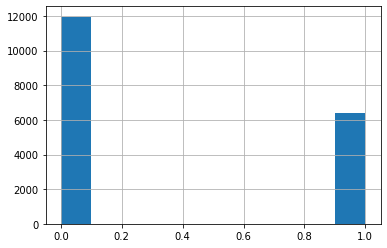

In [ ]:
subset1.label.hist()

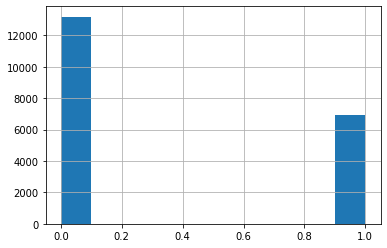

In [ ]:
subset2.label.hist()

In [ ]:
# create Decision Tree classifier object
# weights = {0:1, 1:2}
subset1_clf_etp = DecisionTreeClassifier(criterion="entropy", random_state=4) #, class_weight=weights)

# train 
subset1_clf_etp = subset1_clf_etp.fit(subset1_X, subset1_y)

In [ ]:
# create Decision Tree classifier object
# weights = {0:1, 1:2}
subset2_clf_etp = DecisionTreeClassifier(criterion="entropy", random_state=4) #, class_weight=weights)

# train 
subset2_clf_etp = subset2_clf_etp.fit(subset2_X, subset2_y)

### Experimenting with HistGradientBoostingClassifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier  # numerical cols dont need scaling

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('categorical', categorical_preprocessor, categorical_columns)],
    remainder="passthrough")

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())

In [ ]:
model.fit(data_train)

## Evaluation

In [ ]:
from sklearn import metrics

#### Prepare validation set

In [ ]:
#@title Add indexes
val_df = pd.concat([val_df, pd.DataFrame({'index': np.arange(val_df.shape[0])})], axis=1)

In [ ]:
mask = val_df.cat_5 == 1

#@title Split into 2 subsets
subset1_val = val_df[mask].drop('cat_5', axis=1)

subset2_val = val_df[~mask].drop('cat_5', axis=1)

In [ ]:
#@title Store indexes
subset1_val_index = subset1_val['index']
subset1_val = subset1_val.drop('index', axis=1)

subset2_val_index = subset2_val['index']
subset2_val = subset2_val.drop('index', axis=1)

In [ ]:
subset1_val_y = subset1_val['label']
subset1_val_X = subset1_val.drop('label', axis=1)

In [ ]:
subset2_val_y = subset2_val['label']
subset2_val_X = subset2_val.drop('label', axis=1)

In [ ]:
#@title Clean & Encode
subset1_val_X = clean_sub1(subset1_val_X)
subset1_val_X = encode_sub1(subset1_val_X)

subset2_val_X = clean_sub2(subset2_val_X)
subset2_val_X = encode_sub2(subset2_val_X)

#### Evaluating Random Forest experiment

In [ ]:
val_predicted_subset1 = pd.DataFrame({
    'index':subset1_val_index.index, 
    'predicted': subset1_rf.predict(subset1_val_X)})

val_predicted_subset2  = pd.DataFrame({
    'index':subset2_val_index.index, 
    'predicted': subset2_rf.predict(subset2_val_X)})

val_predicted = pd.concat([val_predicted_subset1, val_predicted_subset2]).sort_values(by=['index']) 

In [ ]:
subset1_val_y = pd.DataFrame({
    'index':subset1_val_index.index, 
    'actual': subset1_val_y})
subset2_val_y = pd.DataFrame({
    'index':subset2_val_index.index, 
    'actual': subset2_val_y})

val_actual =  pd.concat([subset1_val_y, subset2_val_y]).sort_values(by=['index']) 

In [ ]:
# evaluate on val set 1
print(metrics.classification_report(subset1_val_y.actual, val_predicted_subset1.predicted))

              precision    recall  f1-score   support

           0       0.65      0.95      0.77      3014
           1       0.32      0.05      0.08      1637

    accuracy                           0.63      4651
   macro avg       0.48      0.50      0.42      4651
weighted avg       0.53      0.63      0.53      4651



In [ ]:
# evaluate on val set 2
print(metrics.classification_report(subset2_val_y.actual, val_predicted_subset2.predicted))

              precision    recall  f1-score   support

           0       0.66      0.87      0.75      3271
           1       0.37      0.14      0.21      1684

    accuracy                           0.62      4955
   macro avg       0.52      0.51      0.48      4955
weighted avg       0.56      0.62      0.57      4955



In [ ]:
print(metrics.classification_report(val_actual.actual, val_predicted.predicted))

              precision    recall  f1-score   support

           0       0.66      0.91      0.76      6285
           1       0.35      0.10      0.15      3321

    accuracy                           0.63      9606
   macro avg       0.50      0.50      0.46      9606
weighted avg       0.55      0.63      0.55      9606



#### Evaluating XGBoost experiment

In [ ]:
val_predicted_subset1 = pd.DataFrame({
    'index':subset1_val_index.index, 
    'predicted': subset1_xgb.predict(subset1_val_X)})

val_predicted_subset2  = pd.DataFrame({
    'index':subset2_val_index.index, 
    'predicted': subset2_xgb.predict(subset2_val_X)})

val_predicted = pd.concat([val_predicted_subset1, val_predicted_subset2]).sort_values(by=['index']) 

In [ ]:
subset1_val_y = pd.DataFrame({
    'index':subset1_val_index.index, 
    'actual': subset1_val_y})
subset2_val_y = pd.DataFrame({
    'index':subset2_val_index.index, 
    'actual': subset2_val_y})

val_actual =  pd.concat([subset1_val_y, subset2_val_y]).sort_values(by=['index']) 

In [ ]:
# evaluate on val set 1
print(metrics.classification_report(subset1_val_y.actual, val_predicted_subset1.predicted))

              precision    recall  f1-score   support

           0       0.65      0.57      0.60      3014
           1       0.35      0.43      0.39      1637

    accuracy                           0.52      4651
   macro avg       0.50      0.50      0.50      4651
weighted avg       0.54      0.52      0.53      4651



In [ ]:
# evaluate on val set 2
print(metrics.classification_report(subset2_val_y.actual, val_predicted_subset2.predicted))

              precision    recall  f1-score   support

           0       0.66      0.49      0.57      3271
           1       0.34      0.51      0.41      1684

    accuracy                           0.50      4955
   macro avg       0.50      0.50      0.49      4955
weighted avg       0.55      0.50      0.51      4955



In [ ]:
print(metrics.classification_report(val_actual.actual, val_predicted.predicted))

              precision    recall  f1-score   support

           0       0.65      0.53      0.59      6285
           1       0.35      0.47      0.40      3321

    accuracy                           0.51      9606
   macro avg       0.50      0.50      0.49      9606
weighted avg       0.55      0.51      0.52      9606



#### Evaluating Decision Tree Entropy experiment

In [ ]:
val_predicted_subset1 = pd.DataFrame({
    'index':subset1_val_index.index, 
    'predicted': subset1_clf_etp.predict(subset1_val_X)})

val_predicted_subset2  = pd.DataFrame({
    'index':subset2_val_index.index, 
    'predicted': subset2_clf_etp.predict(subset2_val_X)})

val_predicted = pd.concat([val_predicted_subset1, val_predicted_subset2]).sort_values(by=['index']) 

In [ ]:
subset1_val_y = pd.DataFrame({
    'index':subset1_val_index.index, 
    'actual': subset1_val_y.actual})
subset2_val_y = pd.DataFrame({
    'index':subset2_val_index.index, 
    'actual': subset2_val_y.actual})

val_actual =  pd.concat([subset1_val_y, subset2_val_y]).sort_values(by=['index']) 

In [ ]:
print(metrics.classification_report(val_actual.actual, val_predicted.predicted))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      6285
           1       0.35      0.29      0.32      3321

    accuracy                           0.56      9606
   macro avg       0.50      0.50      0.50      9606
weighted avg       0.55      0.56      0.55      9606



#### Evaluating HistGradientBoosting experiment

In [ ]:
# evaluate on training set
y_train_predicted = clf_etp.predict(customer_X_train)
print(metrics.classification_report(customer_y_train, y_train_predicted))

In [ ]:
# evaluate on val set
y_val_predicted = clf_etp.predict(customer_X_val)
print(metrics.classification_report(customer_y_val, y_val_predicted))

## Export Result

Export to a CSV file, with one predicted column 

### Prepare test set 

In [ ]:
#@title Add indexes
test_df = pd.concat([test_df, pd.DataFrame({'index': np.arange(test_df.shape[0])})], axis=1)

In [ ]:
mask_test = test_df.cat_5 == 1
#@title Split into 2 subsets
subset1_test = test_df[mask_test].drop('cat_5', axis=1)

subset2_test = test_df[~mask_test].drop('cat_5', axis=1)

In [ ]:
#@title Store indexes
subset1_test_index = subset1_test['index']
subset1_test = subset1_test.drop('index', axis=1)

subset2_test_index = subset2_test['index']
subset2_test = subset2_test.drop('index', axis=1)

In [ ]:
#@title Clean & Encode
subset1_test = clean_sub1(subset1_test)
subset1_test = encode_sub1(subset1_test)

subset2_test = clean_sub2(subset2_test)
subset2_test = encode_sub2(subset2_test)

### Make prediction

In [ ]:
predicted_subset1 = pd.DataFrame({'index':subset1_test_index, 'predicted': subset1_xgb.predict(subset1_test)})
predicted_subset2 = pd.DataFrame({'index':subset2_test_index, 'predicted': subset2_xgb.predict(subset2_test)})

predicted = pd.concat([predicted_subset1, predicted_subset2]).sort_values(by=['index']) 

### Export results

In [ ]:
y_test_predicted = predicted.predicted

pd.DataFrame(y_test_predicted, columns=['predicted']).to_excel('demo_remake_xgb.xlsx', index=False)

## Submissions

- **Model | Accu  | F1-sco | Prec | Rec**
1. rf_etp | 0.581	| 0.558	|0.332| 0.229
2. etp_rf | 0.608	|0.571|	0.361 |	0.198
3. 
4. nu_etp |0.490|0.503|	0.340 |0.531

## References
- Về bài toán Phát hiện gian lận trong giao dịch ngân hàng
1. https://blog.unicloud.com.vn/ml/vulnerability-detection/
2. https://drsme.edu.vn/machine-learning-ho-tro-phat-hien-gian-lan-trong-nganh-bao-hiem/

- Feature selection cho bài toán này 
1. https://www.researchgate.net/publication/313731885_Feature_Selection_Approaches_to_Fraud_Detection_in_e-Payment_Systems

- Về một số kiến thức + kỹ thuật 
1. https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a
2. https://www.freecodecamp.org/news/feature-engineering-and-feature-selection-for-beginners/
3. https://datascience.stackexchange.com/questions/47409/target-encoding-missing-value-imputation-before-or-after-encoding
4. https://towardsdatascience.com/data-cleaning-how-to-handle-missing-values-in-pandas-cc8570c446ec
5. Xử lý missing value bằng KNN https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa
6. https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96
7. https://lovespreadsheets.medium.com/ultimate-guide-to-cleaning-dates-and-time-faada3cbbefe

## demo_remake (1) - no handling 
                	precision	recall	f1-score	support
            class 0	  0.66	0.71	    0.69	   3299
            class 1  	0.35	0.30    	0.33	   1701

            micro avg			0.57	            5000
            macro avg	0.51	0.56	0.51	    5000
            weighted avg	0.51	0.57	0.56	5000


## demo_remake (2) - handling 
                    precision	recall	f1-score	support
            class 0	   0.65	0.61	    0.63  	3299
            class 1	   0.33	0.37	    0.35      1701
            
            micro avg			   0.53	        5000
            macro avg	   0.49	0.54	0.49	5000
            weighted avg	0.49	0.53	0.54	5000

## demo_remake (3) - handling and remove var 7,8,9,10
ID 501

## demo_remake_xgb - tham số mặc định mà hong nhớ có xử lý mất cân bằng hong nữa
ID 505

## demo_remake_xgb (1) - learning_rate = 0.2, weight=1.15*
ID 506

## demo_remake_xgb (2) - learning_rate = 0.2, weight=1*
ID 507